### Import Required Packages

In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump, load
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input # to get pre-trained model Xception
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer # for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import add, Input, Dense, LSTM, Embedding, Dropout
from keras.utils import plot_model
from tqdm import tqdm
import pandas as pd

tqdm.pandas()  # To add progress bar support to pandas


### Perform Data Cleaning

In [2]:
# Load the document file into memory
def load_fp(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split('\n')  
    descriptions = {}
    for caption in captions[:-1]:  # Skip the last empty line
        img, caption = caption.split('\t')  # Split on tab
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

# Data cleaning function to convert to lowercase, remove punctuations, and words with numbers
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            descp = img_caption.split()
            # Uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            # Remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            # Remove hanging 's and a, and remove words with numbers
            descp = [wrd for wrd in descp if len(wrd) > 1 and wrd.isalpha()]
            # Converting back to string
            img_caption = ' '.join(descp)
            captions[img][i] = img_caption
    return captions

# To build vocab of all unique words
def txt_vocab(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# Save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)  
    data = "\n".join(lines)  
    with open(filename, "w") as file:  # To safely open file
        file.write(data)

# Provide path of dataset
dataset_text = r"D:\Study\Semester 6\CV\Project\Flickr_8k_text"
dataset_images = r"D:\Study\Semester 6\CV\Project\Flickr_8k_Dataset"

# To prepare our text data
filename = dataset_text + "\\" + "Flickr8k.token.txt"

# Loading the file that contains all data
descriptions = img_capt(filename)
print("Length of descriptions =", len(descriptions))

# Cleaning the descriptions
clean_descriptions = txt_clean(descriptions)

# To build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

# Saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")


Length of descriptions = 8092
Length of vocabulary = 8422


### Extract the Feature Vectors

In [4]:
# Extract feature vectors from images
def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')  # Pre-trained Xception model
    features = {}
    
    for pic in tqdm(os.listdir(directory)):  # Using tqdm to show progress bar
        file_path = os.path.join(directory, pic)  
        
        # Load and preprocess image
        image = Image.open(file_path)
        image = image.resize((299, 299))  # Resize to Xception input size
        image = img_to_array(image)  # Convert to NumPy array
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        image = preprocess_input(image)  # Preprocess the image for Xception
        
        # Extract features
        feature = model.predict(image, verbose=0)
        features[pic] = feature  # Use `pic` (filename) as the key
    
    return features

# Extract features from dataset images
features = extract_features(dataset_images)

# Save the features to a pickle file
with open("features.p", "wb") as f:
    dump(features, f)

# Load the features from the pickle file
with open("features.p", "rb") as f:
    features = load(f)

100%|██████████| 8091/8091 [59:58<00:00,  2.25it/s]  


### Loading Dataset for Model Training

In [3]:
# Load the document file into memory
def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Load the list of image IDs (photo names)
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split('\n')[:-1]  # To split by newline and ignore last empty line
    return photos

# Load clean descriptions for the specified photos
def load_clean_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = {}
    
    for line in file.split('\n'):
        words = line.split()
        if len(words) < 1:  # Skip empty lines
            continue
        image, image_caption = words[0], words[1:]
        
        if image in photos:  # Only use descriptions for images in the specified photos
            if image not in descriptions:
                descriptions[image] = []
            desc = ' ' + " ".join(image_caption) + ' '  # Create caption string
            descriptions[image].append(desc)  # Add caption to the image descriptions
            
    return descriptions

# Load features for the specified photos
def load_features(photos):
    all_features = load(open("features.p", "rb"))  # Load pre-extracted features
    
    # Select only the features corresponding to the photos in the list
    features = {k: all_features[k] for k in photos if k in all_features}  # Handle missing keys
    return features

# Dataset paths
filename = dataset_text + "\\" + "Flickr_8k.trainImages.txt"

# Load training data
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

# Check loaded data
print("Number of training images:", len(train_imgs))
print("Number of training descriptions:", len(train_descriptions))
print("Number of training features:", len(train_features))

Number of training images: 6000
Number of training descriptions: 6000
Number of training features: 6000


### Tokenizing the Vocabulary

In [4]:
# Convert dictionary of descriptions to a list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]  
    return all_desc

# Create tokenizer: vectorize text corpus, where each integer represents a token
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)  # Fit the tokenizer on the list of descriptions
    return tokenizer

# Tokenize the descriptions
tokenizer = create_tokenizer(train_descriptions)

# Save the tokenizer to a pickle file
dump(tokenizer, open('tokenizer.p', 'wb'))

# Calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token
print(f"Vocabulary size: {vocab_size}")  # Output vocabulary size

# Calculate the maximum length of descriptions to determine model structure
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)  # Return the maximum length

max_length = max_length(train_descriptions)
print(f"Maximum length of description: {max_length}")  # Output maximum length

Vocabulary size: 7318
Maximum length of description: 33


### Creating a Data Generator

In [7]:
# Data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while True:  # Infinite loop for generator
        for key, description_list in descriptions.items():
            # Retrieve photo features
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]

# Create sequences for input-output pairs
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()  # Input image features, input sequences, output words
    
    # Iterate over each description for the image
    for desc in desc_list:
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # Divide one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
            # Split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # Pad input sequence to max_length
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # One-hot encode the output word
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            # Store
            x_1.append(feature)  # The image feature (X1)
            x_2.append(in_seq)   # The input sequence (X2)
            y.append(out_seq)    # The output word (Y)
    
    return np.array(x_1), np.array(x_2), np.array(y)

# To check the shape of the input and output for your model
[a, b], c = next(data_generator(train_descriptions, train_features, tokenizer, max_length))
print(a.shape, b.shape, c.shape)

# Expected Output:
# a.shape = (batch_size, 2048) -> Image feature vector
# b.shape = (batch_size, max_length) -> Input sequence (padded captions)
# c.shape = (batch_size, vocab_size) -> One-hot encoded output word

(37, 2048) (37, 33) (37, 7318)


### Defining the CNN-RNN Model

In [8]:
# Define the captioning model
def define_model(vocab_size, max_length):
    # Feature extractor model (CNN part)
    inputs1 = Input(shape=(2048,))  # Input for image features (from CNN)
    fe1 = Dropout(0.5)(inputs1)  # Apply dropout to prevent overfitting
    fe2 = Dense(256, activation='relu')(fe1)  # Reduce dimensions to 256

    # Sequence model (RNN part)
    inputs2 = Input(shape=(max_length,))  # Input for text sequences
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)  # Embed word sequences
    se2 = Dropout(0.5)(se1)  # Dropout to prevent overfitting
    se3 = LSTM(256)(se2)  # LSTM layer with 256 units

    # Merging both models
    decoder1 = add([fe2, se3])  # Merge image and text features
    decoder2 = Dense(256, activation='relu')(decoder1)  # Add dense layer after merging
    outputs = Dense(vocab_size, activation='softmax')(decoder2)  # Output layer with softmax activation

    # Define the model with two inputs (image features and text sequence) and one output (predicted word)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Summarize the model
    model.summary()

    # Plot model graph
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

# Example of how to use the model
vocab_size = 7577  # Example vocabulary size
max_length = 32  # Example max length of sequences
model = define_model(vocab_size, max_length)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

### Training the Image Caption Generator Model

In [19]:
# Set up the training parameters
epochs = 200
batch_size = 32  
steps_per_epoch = len(train_descriptions) // batch_size  # Steps for training
validation_split = 0.2  # 20% of data will be used for validation

# Split the training data into training and validation sets
train_size = int(len(train_descriptions) * (1 - validation_split))
train_imgs_split = train_imgs[:train_size]
val_imgs_split = train_imgs[train_size:]

# Load training and validation data
train_descriptions_split = {k: train_descriptions[k] for k in train_imgs_split}
val_descriptions_split = {k: train_descriptions[k] for k in val_imgs_split}

train_features_split = {k: train_features[k] for k in train_imgs_split}
val_features_split = {k: train_features[k] for k in val_imgs_split}

# Calculate validation steps
validation_steps = len(val_descriptions_split) // batch_size

print(f"Training on {len(train_imgs_split)} images, validating on {len(val_imgs_split)} images.")

# Define the model
model = define_model(vocab_size, max_length)

# Ensure the "models" directory exists
if not os.path.exists("models"):
    os.mkdir("models")

# Training loop
for epoch in range(epochs):
    # Create generators for both training and validation
    train_generator = data_generator(train_descriptions_split, train_features_split, tokenizer, max_length)
    val_generator = data_generator(val_descriptions_split, val_features_split, tokenizer, max_length)

    # Fit the model with validation data
    model.fit(
        train_generator,
        epochs=1,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        verbose=1
    )
    
    # Save the model after each epoch
    model.save(f"models/model_epoch_{epoch+1}.h5")
    print(f"Model saved for epoch {epoch+1}")

Training on 4800 images, validating on 1200 images.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 32, 256)      1939712     ['input_9[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 2048)         0           ['input_8[0][0]']                
                                        

### Testing the Model

In [9]:
import sacrebleu

# Function to generate a caption for a given image
def generate_caption(model, tokenizer, photo, max_length):
    # Start with the 'startseq' token
    in_text = 'startseq'
    
    # Loop until the maximum caption length is reached
    for i in range(max_length):
        # Convert the current text to a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to the maximum length
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict the next word
        yhat = model.predict([photo, sequence], verbose=0)
        
        # Get the index of the predicted word
        yhat = np.argmax(yhat)
        # Convert the index back to the word
        word = tokenizer.index_word.get(yhat, None)
        
        # Stop if we can't map the predicted index to a word
        if word is None:
            break
        
        # Append the predicted word to the current caption
        in_text += ' ' + word
        
        # Stop if 'endseq' token is generated
        if word == 'endseq':
            break
    
    # Remove the 'startseq' token and return the generated caption
    return in_text.split()[1:-1]

# Function to calculate BLEU score for a set of captions
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()

    # Iterate over each image and its descriptions in the test set
    for key, desc_list in tqdm(descriptions.items(), desc="Evaluating captions", ncols=100):
        # Generate a caption for the image
        y_pred = generate_caption(model, tokenizer, photos[key], max_length)
        predicted.append(' '.join(y_pred))  # Store the predicted caption
        
        # Store the actual captions (ground truth)
        references = [' '.join(d.split()) for d in desc_list]
        actual.append(references)
    
    # Calculate BLEU-1 and BLEU-2 using sacrebleu
    bleu_1 = sacrebleu.corpus_bleu(predicted, [list(references) for references in actual], smooth_method="exp").score
    bleu_2 = sacrebleu.corpus_bleu(predicted, [list(references) for references in actual], smooth_method="exp").score
    
    print(f'BLEU-1: {bleu_1:.2f}')
    print(f'BLEU-2: {bleu_2:.2f}')

# Dataset paths
dataset_text = r"D:\Study\Semester 6\CV\Project\Flickr_8k_text"  

# Load the model for testing
from keras.models import load_model
model = load_model('models/model_epoch_200.h5')

# Load tokenizer, test features, and descriptions for test images
filename = dataset_text + "\\" + "Flickr_8k.testImages.txt"
test_imgs = load_photos(filename)
test_descriptions = load_clean_descriptions('descriptions.txt', test_imgs)
test_features = load_features(test_imgs)

# Generate predictions and evaluate BLEU
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)



Evaluating captions: 100%|██████████████████████████████████████| 1000/1000 [50:18<00:00,  3.02s/it]


BLEU-1: 22.16
BLEU-2: 22.16


### Testing the Image Caption Generator Model

1/1 [==============================] - 2s 2s/step

Generated Caption:
start plays the slide in the grass field with blue ball and one runs by trees for the camera to the toy to the camera ground and blue toy to the trees out


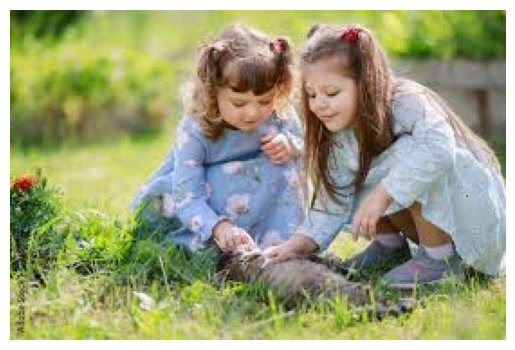

In [12]:
import matplotlib.pyplot as plt

# Image path 
img_path = 'test.jpg'

# Function to extract features from the image using the Xception model
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct.")
        return None
    
    image = image.resize((299, 299))  # Resize to match Xception input size
    image = np.array(image)

    # Convert images with 4 channels (e.g., RGBA) to 3 channels (RGB)
    if len(image.shape) == 3 and image.shape[2] == 4:
        image = image[..., :3]

    # Preprocessing for Xception model
    image = np.expand_dims(image, axis=0)
    image = image / 127.5 - 1.0  # Normalize pixel values

    # Extract features
    feature = model.predict(image)
    return feature

# Function to map predicted word index to actual word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate description from the image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict the next word
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        
        # Map predicted integer to word
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break

    return in_text

# Maximum length of description (defined during training)
max_length = 32

# Load the tokenizer and the trained model
tokenizer = load(open("tokenizer.p", "rb"))
model = load_model('models/model_epoch_200.h5')

# Load the Xception model for feature extraction
xception_model = Xception(include_top=False, pooling="avg")

# Extract features from the image
photo = extract_features(img_path, xception_model)

# Open the image to display
img = Image.open(img_path)

# Generate the description using the model
description = generate_desc(model, tokenizer, photo, max_length)

# Display the results
print("\nGenerated Caption:")
print(description)

plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()